# Prediction of Protein Subcellular Localization

This project focuses on predicting the subcellular localization of proteins using deep learning models. The input data consists of protein sequences that have already been processed into numerical representations. Specifically, the data includes:

- **Protein sequences**: Each protein sequence is represented as a NumPy array: 2,423 protein sequences, each of which has been padded or truncated to a length of 400. Each position in the sequence is represented by a 20-dimensional feature vector, which is a one-hot encoding of the amino acid at that position.

- **Sequence masks**: A NumPy array that defines valid regions of the sequence: protein sequences vary in length, but neural networks require inputs of uniform size. To handle this, sequences are padded to a fixed length (400). The sequence mask is a binary array that indicates which positions in the sequence are valid (1) and which are padded (0).

- **Protein localizations**: A NumPy vector containing the subcellular localization labels for each protein: 2,423 labels corresponding to the subcellular localization for each protein sequence.

### Load the libraries

In [1]:
from collections import Counter
import os
import requests

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Set a color palette
sns.set(style="whitegrid")


2024-09-25 13:05:36.721840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 13:05:37.637685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data

In [2]:
def download_data():
    url=("https://github.com/JJAlmagro/subcellular_localization/raw/refs/"
         "heads/master/notebook%20tutorial/data/reduced_train.npz")
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    if not os.path.exists(FilePath):
        download_file(url, FilePath)


In [3]:
download_data()

In [4]:
file_data = "dataset/reduced_train.npz"
data = np.load(file_data)

X = data["X_train"]
y_raw = data["y_train"]
mask = data["mask_train"]

print(f"X shape: {X.shape}")
print(f"y shape: {y_raw.shape}")
print(f"mask shape: {mask.shape}")

classes = LabelEncoder()
classes.fit(y_raw)
y = classes.transform(y_raw)
y = to_categorical(y)

print(f"one-hot encoded y shape: {y.shape}")


X shape: (2423, 400, 20)
y shape: (2423,)
mask shape: (2423, 400)
one-hot encoded y shape: (2423, 10)


### Define auxiliary functions

In [5]:
def plot_training_roc(history, y_test, y_pred_proba, n_classes=10):
    """Plot training history and ROC curves for each class."""
    # Initialize subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')

    # ROC Curves for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        axs[2].plot(fpr[i], tpr[i], 
                    label=f"Class {i} (area = {roc_auc[i]:.2f})")

    # Plot diagonal line for random classifier
    axs[2].plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    axs[2].set_title('ROC Curves for Each Class')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend(loc='lower right')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    
def pad_sequences(seq_list, pad_value=None):
    """Pad sequences to the same length with the provided pad_value."""
    max_length = max(len(seq) for seq in seq_list)
    padded_seqs = []
    for seq in seq_list:
        if len(seq) < max_length:
            # Pad with the last value or a specified pad_value
            padding_value = seq[-1] if pad_value is None else pad_value
            padded_seq = seq + [padding_value] * (max_length - len(seq))
        else:
            padded_seq = seq
        padded_seqs.append(padded_seq)
    return np.array(padded_seqs)

def plot_cross_validation_results(histories, 
                                  test_accuracies, 
                                  y_test, 
                                  y_pred_probas, 
                                  n_classes=10):
    """Plot mean training history and ROC curves across folds."""
    # Extract train and validation accuracies and losses
    train_accuracies = pad_sequences([history.history['accuracy'] 
                                      for history in histories])
    val_accuracies = pad_sequences([history.history['val_accuracy'] 
                                    for history in histories])
    train_losses = pad_sequences([history.history['loss'] 
                                  for history in histories])
    val_losses = pad_sequences([history.history['val_loss'] 
                                for history in histories])

    # Calculate mean and std for accuracies and losses
    mean_train_acc = np.mean(train_accuracies, axis=0)
    std_train_acc = np.std(train_accuracies, axis=0)
    mean_val_acc = np.mean(val_accuracies, axis=0)
    std_val_acc = np.std(val_accuracies, axis=0)
    
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0)
    mean_val_loss = np.mean(val_losses, axis=0)
    std_val_loss = np.std(val_losses, axis=0)

    epochs = range(train_accuracies.shape[1])

    # Initialize subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Accuracy plot
    axs[0].plot(epochs, mean_train_acc, label='Train Accuracy (mean)')
    axs[0].fill_between(epochs, mean_train_acc - std_train_acc, 
                        mean_train_acc + std_train_acc, alpha=0.2)
    axs[0].plot(epochs, mean_val_acc, label='Validation Accuracy (mean)')
    axs[0].fill_between(epochs, mean_val_acc - std_val_acc, 
                        mean_val_acc + std_val_acc, alpha=0.2)
    axs[0].set_title('Accuracy Across Folds')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    # Loss plot
    axs[1].plot(epochs, mean_train_loss, label='Train Loss (mean)')
    axs[1].fill_between(epochs, mean_train_loss - std_train_loss, 
                        mean_train_loss + std_train_loss, alpha=0.2)
    axs[1].plot(epochs, mean_val_loss, label='Validation Loss (mean)')
    axs[1].fill_between(epochs, mean_val_loss - std_val_loss, 
                        mean_val_loss + std_val_loss, alpha=0.2)
    axs[1].set_title('Loss Across Folds')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')

    # ROC Curve for each class
    mean_fpr = np.linspace(0, 1, 100)  # Common FPR for interpolation
    tprs = {i: [] for i in range(n_classes)}
    aucs = {i: [] for i in range(n_classes)}
    
    for y_pred_proba in y_pred_probas:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            tprs[i].append(np.interp(mean_fpr, fpr[i], tpr[i]))  
            tprs[i][-1][0] = 0.0  # Ensure TPR starts at 0
            roc_auc[i] = auc(fpr[i], tpr[i])
            aucs[i].append(roc_auc[i])

    # Plot ROC Curves for each class
    for i in range(n_classes):
        mean_tpr = np.mean(tprs[i], axis=0)
        mean_tpr[-1] = 1.0  # Ensure TPR ends at 1
        std_tpr = np.std(tprs[i], axis=0)
        mean_auc = np.mean(aucs[i])
        std_auc = np.std(aucs[i])
        
        axs[2].plot(mean_fpr, mean_tpr, 
                    label=f'Class {i} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
        axs[2].fill_between(mean_fpr, mean_tpr - std_tpr, 
                            mean_tpr + std_tpr, alpha=0.2)

    axs[2].plot([0, 1], [0, 1], linestyle='--', 
                color='black', label="Random Classifier")
    axs[2].set_title('ROC Curves (Mean ± STD) for Each Class')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend(loc='lower right')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

def cross_validate_model(create_model_func, x_train, y_train, x_test, y_test,
                         class_weights_dict, n_splits=5, batch_size=64, 
                         epochs=200, patience=5, model_type='cnn'):
    """Perform k-fold cross-validation for a given model."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    val_acc_per_fold = []
    test_acc_per_fold = []
    histories = []
    test_accuracies = []
    y_pred_probas = []

    for fold, (train_index, val_index) in enumerate(skf.split(x_train, 
                                                              np.argmax(y_train, 
                                                                        axis=1))):
        print(f"Training fold {fold+1}/{n_splits}...")

        # Split the data into train and validation sets
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create a new model instance for each fold
        model = create_model_func()

        # Add early stopping and model checkpointing
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
            ModelCheckpoint(f'best_{model_type}_model_fold_{fold+1}.keras', 
                            monitor='val_loss', save_best_only=True, verbose=0)
        ]

        # Train the model with the current fold's data
        history = model.fit(
            x_train_fold, y_train_fold, 
            epochs=epochs, batch_size=batch_size, 
            validation_data=(x_val_fold, y_val_fold),
            verbose=0, callbacks=callbacks,
            class_weight=class_weights_dict
        )

        # Evaluate the model on the validation set and store the accuracy
        val_loss, val_accuracy = model.evaluate(x_val_fold, 
                                                      y_val_fold, 
                                                      verbose=0)[:2]
        val_acc_per_fold.append(val_accuracy)
        print(f"Validation accuracy for fold {fold+1}: {val_accuracy * 100:.2f}%")

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(x_test, 
                                                        y_test, 
                                                        verbose=0)[:2]
        test_acc_per_fold.append(test_accuracy)
        print(f"Test accuracy for fold {fold+1}: {test_accuracy * 100:.2f}%")

        # Append history, test accuracy, and predicted probabilities
        histories.append(history)
        test_accuracies.append(test_accuracy)
        y_pred_probas.append(model.predict(x_test, verbose=0))

    # Calculate and print the average validation and test accuracy
    print()
    print(f"Validation accuracy: {np.mean(val_acc_per_fold) * 100:.2f}% ± "
          f"{np.std(val_acc_per_fold) * 100:.2f}%")
    print(f"Test accuracy: {np.mean(test_acc_per_fold) * 100:.2f}% ± "
          f"{np.std(test_acc_per_fold) * 100:.2f}%")

    return histories, test_accuracies, y_pred_probas

### Explore the data

In [6]:
# Check if there are any NaNs

print(f"NaN in X: {np.isnan(X).sum()}")
print(f"NaN in y: {np.isnan(y).sum()}")


NaN in X: 0
NaN in y: 0


In [7]:
# Describe the data

df = pd.DataFrame(X.reshape(-1, X.shape[-1])) # reshape to 2D
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.00000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000,969200.000000
mean,0.044613,0.032232,0.025402,0.029882,0.014102,0.024944,0.036783,0.039004,0.015227,0.029688,0.052408,0.035140,0.01552,0.023623,0.031559,0.045138,0.033516,0.008295,0.018468,0.038108
std,0.094183,0.084780,0.065991,0.081305,0.077116,0.063956,0.088167,0.111841,0.052342,0.075038,0.119778,0.085637,0.05772,0.076689,0.097041,0.088100,0.074305,0.052835,0.069898,0.087309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.050000,0.030000,0.030000,0.030000,0.010000,0.030000,0.040000,0.030000,0.020000,0.030000,0.050000,0.040000,0.01000,0.020000,0.020000,0.060000,0.040000,0.000000,0.010000,0.040000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that the data does not need normalization, as the values are already between 0 and 1.

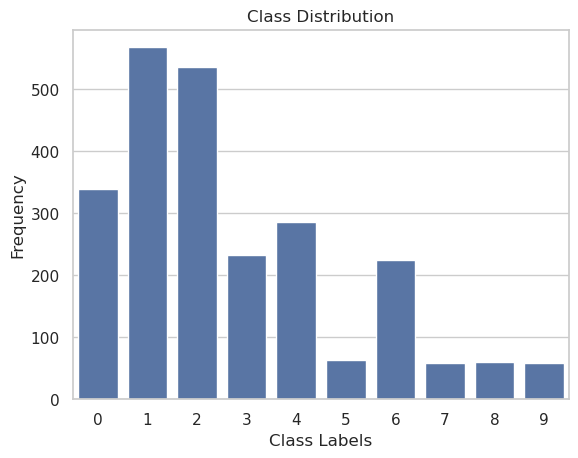

In [8]:
# Visualize class distribution

class_counts = Counter(y_raw)
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


We can observe the class imbalance in the dataset that we will need to address during the model training.

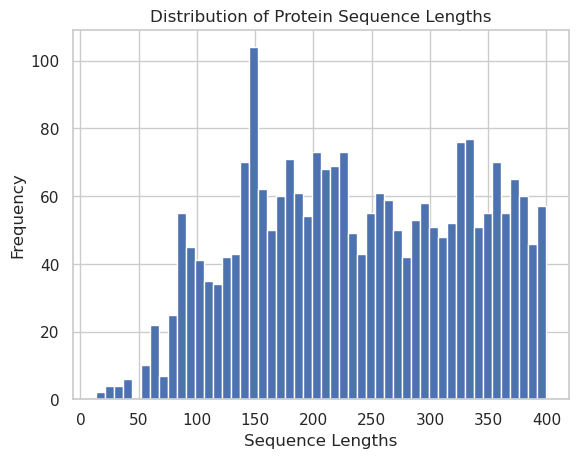

In [9]:
# Visualize the distribution of sequence lengths

sequence_lengths = np.sum(mask, axis=1)
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Lengths')
plt.ylabel('Frequency')
plt.title('Distribution of Protein Sequence Lengths')
plt.show()


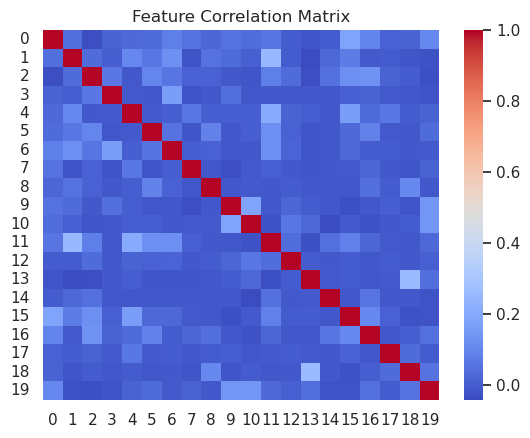

In [10]:
# Visualize the correlation matrix of the features

profile_df = pd.DataFrame(X[0])
corr_matrix = profile_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


### Dimensionality reduction

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as UMAP

/home/nadia/miniconda3/envs/deep-learning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


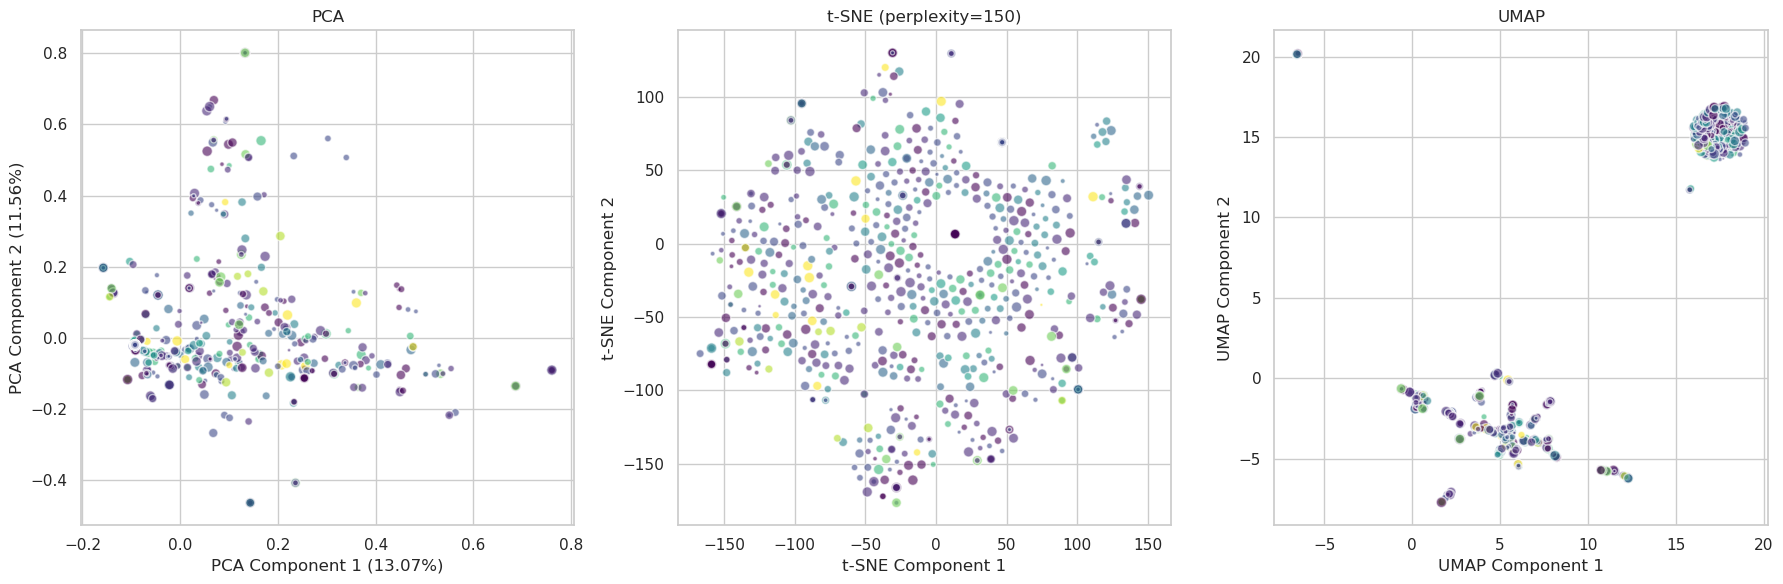

In [12]:
# Flatten sequences into 2D
X_flattened = X.reshape(-1, X.shape[-1])

# Calculate sequence lengths
sequence_lengths = np.sum(mask, axis=1)

# Limit number of samples for uniformity
num_samples = min(1000, X_flattened.shape[0]) 

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flattened[:num_samples])

# Get explained variance ratio for PCA
explained_variance = pca.explained_variance_ratio_

# Perform t-SNE 
tsne_perplexity = 150
X_tsne = TSNE(
    n_components=2, 
    perplexity=tsne_perplexity
    ).fit_transform(X_flattened[:num_samples])

# Perform UMAP 
umap_reducer = UMAP.UMAP(n_components=2)
X_umap = umap_reducer.fit_transform(X_flattened[:num_samples])

# Create a colormap for classes
unique_classes = np.unique(y_raw[:num_samples])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

# Create subplots for t-SNE, PCA, and UMAP
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to assign colors based on class
def get_colors(y_raw, unique_classes):
    return [colors[np.where(unique_classes == label)[0][0]] for label in y_raw]

# PCA scatter plot
scatter_pca = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    s=sequence_lengths[:num_samples] / 7,  # Scale point sizes
    c=get_colors(y_raw[:num_samples], unique_classes), 
    alpha=0.6, edgecolor='w'
)
axes[0].set_title('PCA')
axes[0].set_xlabel(f'PCA Component 1 ({explained_variance[0]*100:.2f}%)')
axes[0].set_ylabel(f'PCA Component 2 ({explained_variance[1]*100:.2f}%)')

# t-SNE scatter plot
scatter_tsne = axes[1].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    s=sequence_lengths[:num_samples] / 7,  # Scale point sizes
    c=get_colors(y_raw[:num_samples], unique_classes), 
    alpha=0.6, edgecolor='w'
)
axes[1].set_title(f't-SNE (perplexity={tsne_perplexity})')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

# UMAP scatter plot
scatter_umap = axes[2].scatter(
    X_umap[:, 0], X_umap[:, 1],
    s=sequence_lengths[:num_samples] / 7,  # Scale point sizes
    c=get_colors(y_raw[:num_samples], unique_classes),
    alpha=0.6, edgecolor='w'
)
axes[2].set_title('UMAP')
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')

plt.tight_layout()
plt.show()


Based on the t-SNE visualization, we can observe clustering patterns in the data, which suggests that some sequences share similarities in their encoded profiles. The circular cluster seems to be interesting, as it indicates that those protein sequences may have very similar profile encodings compared to other more dispersed clusters.

By visualising points size according to the protein length we can see that this cluster is not an artifact of the protein length, as the points are distributed across the entire range of protein lengths.

We can also observe a cluster in UMAP visualization, but we can not conclude conclude that it is formed by the same proteins as in the t-SNE visualization.

### Preprocess data

In [13]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [14]:
# Split data into training and testing sets, including mask
x_train, x_test, y_train, y_test, mask_train, mask_test = train_test_split(
    X, y_raw, mask, test_size=0.2, random_state=42
)

# Shuffle the data
x_train, y_train, mask_train = shuffle(x_train, y_train, mask_train, random_state=42)
x_test, y_test, mask_test = shuffle(x_test, y_test, mask_test, random_state=42)

# Print the shapes of the training and testing sets 
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}") 
print(f"mask_train shape: {mask_train.shape}")
print(f"mask_test shape: {mask_test.shape}")

X_train shape: (1938, 400, 20)
y_train shape: (1938,)
X_test shape: (485, 400, 20)
y_test shape: (485,)
mask_train shape: (1938, 400)
mask_test shape: (485, 400)


In [15]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(y_train), 
                                                  y=y_train)

# Convert the class weights into a dictionary to pass to Keras
class_weights_dict = dict(enumerate(class_weights))

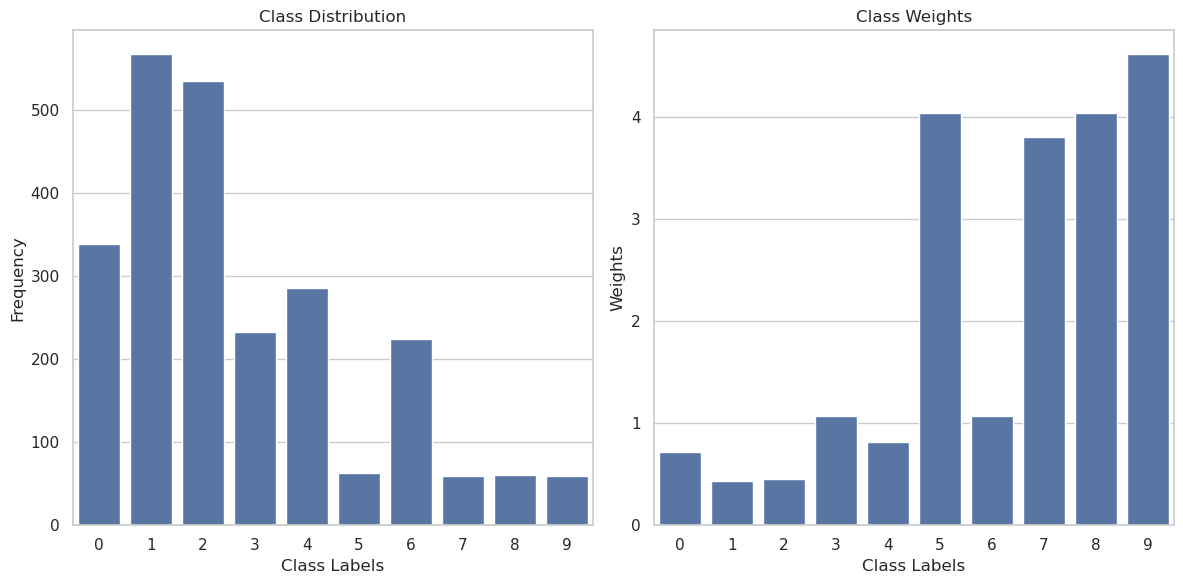

In [16]:
# Visualize class weights and class distribution

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axs[0])
axs[0].set_xlabel('Class Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Class Distribution')

# Plot class weights
sns.barplot(x=list(class_weights_dict.keys()), y=list(class_weights_dict.values()), ax=axs[1])
axs[1].set_xlabel('Class Labels')
axs[1].set_ylabel('Weights')
axs[1].set_title('Class Weights')

# Adjust layout
plt.tight_layout()
plt.show()



### Test logistic regression model with class weights

First, we will test a logistic regression model to establish a baseline performance.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from sklearn.model_selection import StratifiedKFold, cross_val_score

Cross-validated Accuracy: 77.25% (± 2.13%)


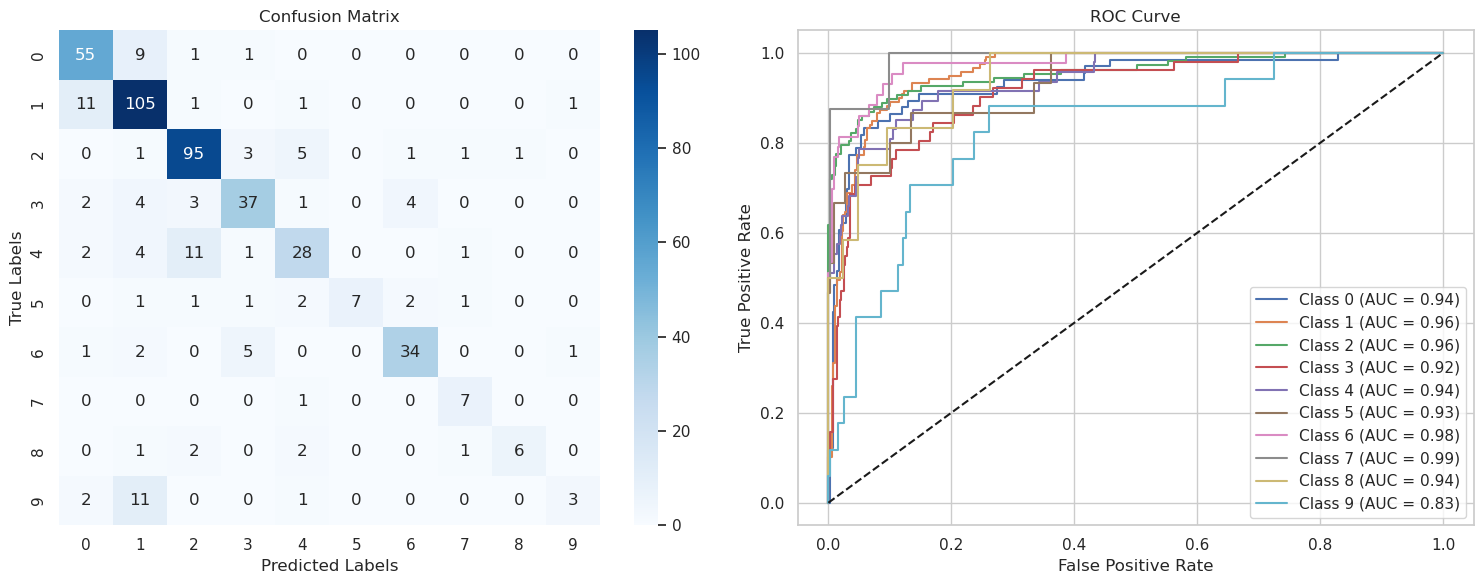

In [18]:
# Initialize and train logistic regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Reshape x to 2D
x_train_flat = x_train.reshape(x_train.shape[0], -1)  
x_test_flat = x_test.reshape(x_test.shape[0], -1) 

# Perform stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(logreg, x_train_flat, y_train, cv=skf)
print(f"Cross-validated Accuracy: {np.mean(cv_scores) * 100:.2f}% "
      f"(± {np.std(cv_scores) * 100:.2f}%)")

# Fit the model on the full training set
logreg.fit(x_train_flat, y_train)

# Make predictions on the test set
y_pred = logreg.predict(x_test_flat)

# Create a figure with subplots
plt.figure(figsize=(15, 6))

# Plot Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Plot ROC Curves for each class 
plt.subplot(1, 2, 2)
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test == i, 
                            logreg.decision_function(x_test_flat)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

The logistic regression model achieved an accuracy of 77.25% ± 2.13%. We can now try to outperform this model using neural network models.

### Test fully connected neural network model with class weights

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten

In [20]:
# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [21]:
def create_dense_model(neurons_1=256, neurons_2=128, 
                       dropout_rate=0.3, learning_rate=0.0001):
    # Initialize the model
    model = Sequential()
    model.add(Input(shape=(400, 20)))
    model.add(Flatten())
    model.add(Dense(neurons_1, activation='relu')) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                weighted_metrics=['accuracy'])
    
    return model

dense_model = create_dense_model()
dense_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,048,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,082,442 (7.94 MB)

 Trainable params: 2,082,442 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Cross-validate dense model
histories_dense, test_accuracies_dense, y_pred_probas_dense = cross_validate_model(
    create_model_func=create_dense_model,
    x_train=x_train, y_train=y_train,
    x_test=x_test, y_test=y_test,
    class_weights_dict=class_weights_dict,
    model_type='dense'
)

Training fold 1/5...
Epoch 40: early stopping
Validation accuracy for fold 1: 72.68%
Test accuracy for fold 1: 75.46%
Training fold 2/5...
Epoch 46: early stopping
Validation accuracy for fold 2: 76.80%
Test accuracy for fold 2: 74.43%
Training fold 3/5...
Epoch 41: early stopping
Validation accuracy for fold 3: 76.55%
Test accuracy for fold 3: 74.43%
Training fold 4/5...
Epoch 39: early stopping
Validation accuracy for fold 4: 76.23%
Test accuracy for fold 4: 75.88%
Training fold 5/5...
Epoch 44: early stopping
Validation accuracy for fold 5: 76.23%
Test accuracy for fold 5: 75.26%

Validation accuracy: 75.70% ± 1.52%
Test accuracy: 75.09% ± 0.57%


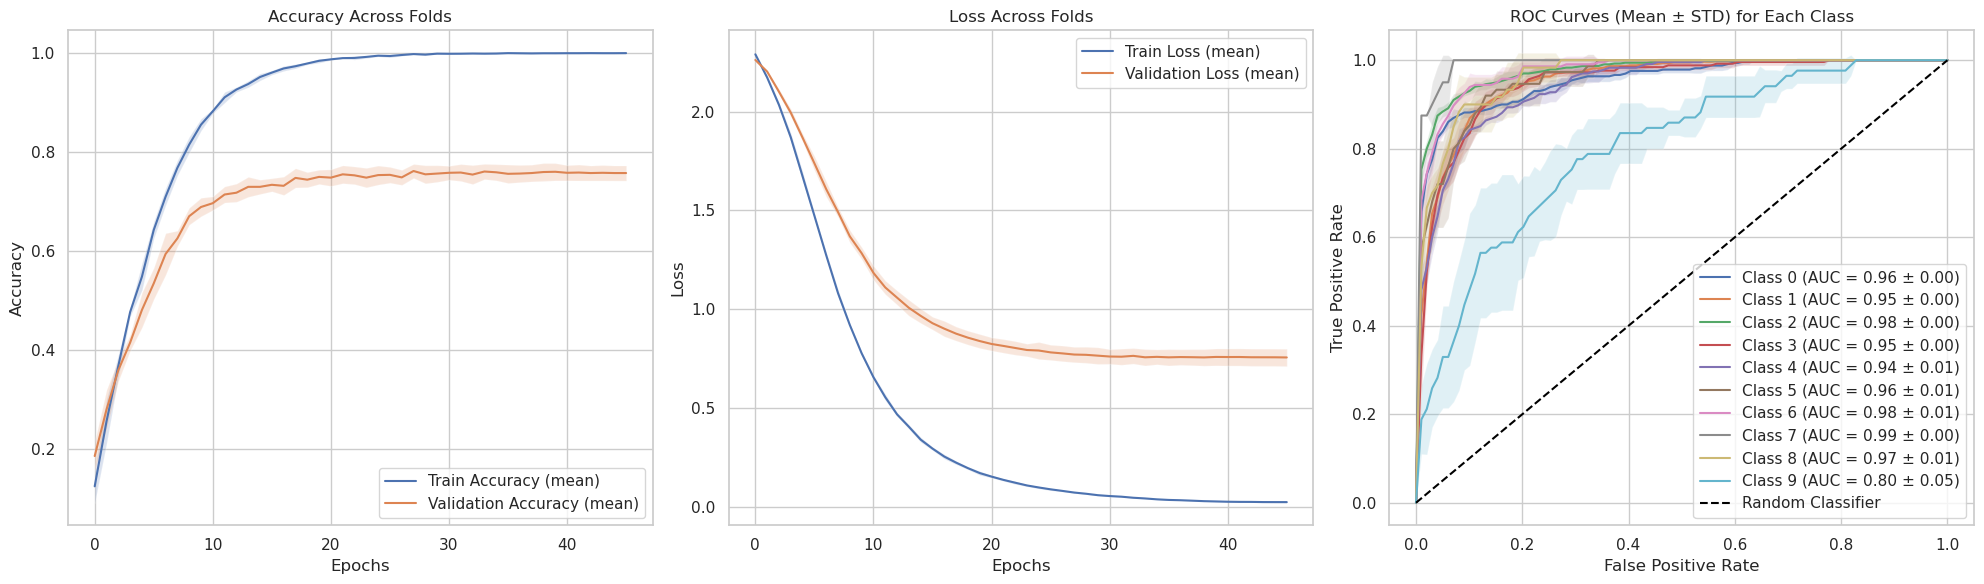

In [23]:
# Plot the results for all folds
plot_cross_validation_results(histories_dense, test_accuracies_dense,
                              y_test, y_pred_probas_dense)

### Test convolutional neural network model

In [24]:
from sklearn.model_selection import StratifiedKFold
from keras.layers import Conv1D

In [25]:
def create_cnn_model(nb_conv=2, nb_dense=0,
                     dropout_rate=0.1, learning_rate=0.0001):
    # Initialize the model
    model = Sequential()
    model.add(Input(shape=(400, 20))) 
    for i in range(nb_conv):
        model.add(Conv1D(32 * (i+1), 3, activation='relu')) 
    model.add(Flatten())
    for i in range(nb_dense):
        model.add(Dropout(dropout_rate))
        model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])
    
    return model

cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 398, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 396, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25344)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │       253,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,610 (1021.91 KB)

 Trainable params: 261,610 (1021.91 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Cross-validate CNN model
histories_cnn, test_accuracies_cnn, y_pred_probas_cnn = cross_validate_model(
    create_model_func=create_cnn_model,
    x_train=x_train, y_train=y_train,
    x_test=x_test, y_test=y_test,
    class_weights_dict=class_weights_dict,
    model_type='cnn'
)

Training fold 1/5...
Epoch 46: early stopping
Validation accuracy for fold 1: 74.23%
Test accuracy for fold 1: 72.37%
Training fold 2/5...
Epoch 67: early stopping
Validation accuracy for fold 2: 73.71%
Test accuracy for fold 2: 69.48%
Training fold 3/5...
Epoch 78: early stopping
Validation accuracy for fold 3: 77.84%
Test accuracy for fold 3: 75.05%
Training fold 4/5...
Epoch 54: early stopping
Validation accuracy for fold 4: 78.04%
Test accuracy for fold 4: 74.02%
Training fold 5/5...
Epoch 65: early stopping
Validation accuracy for fold 5: 74.68%
Test accuracy for fold 5: 75.05%

Validation accuracy: 75.70% ± 1.85%
Test accuracy: 73.20% ± 2.10%


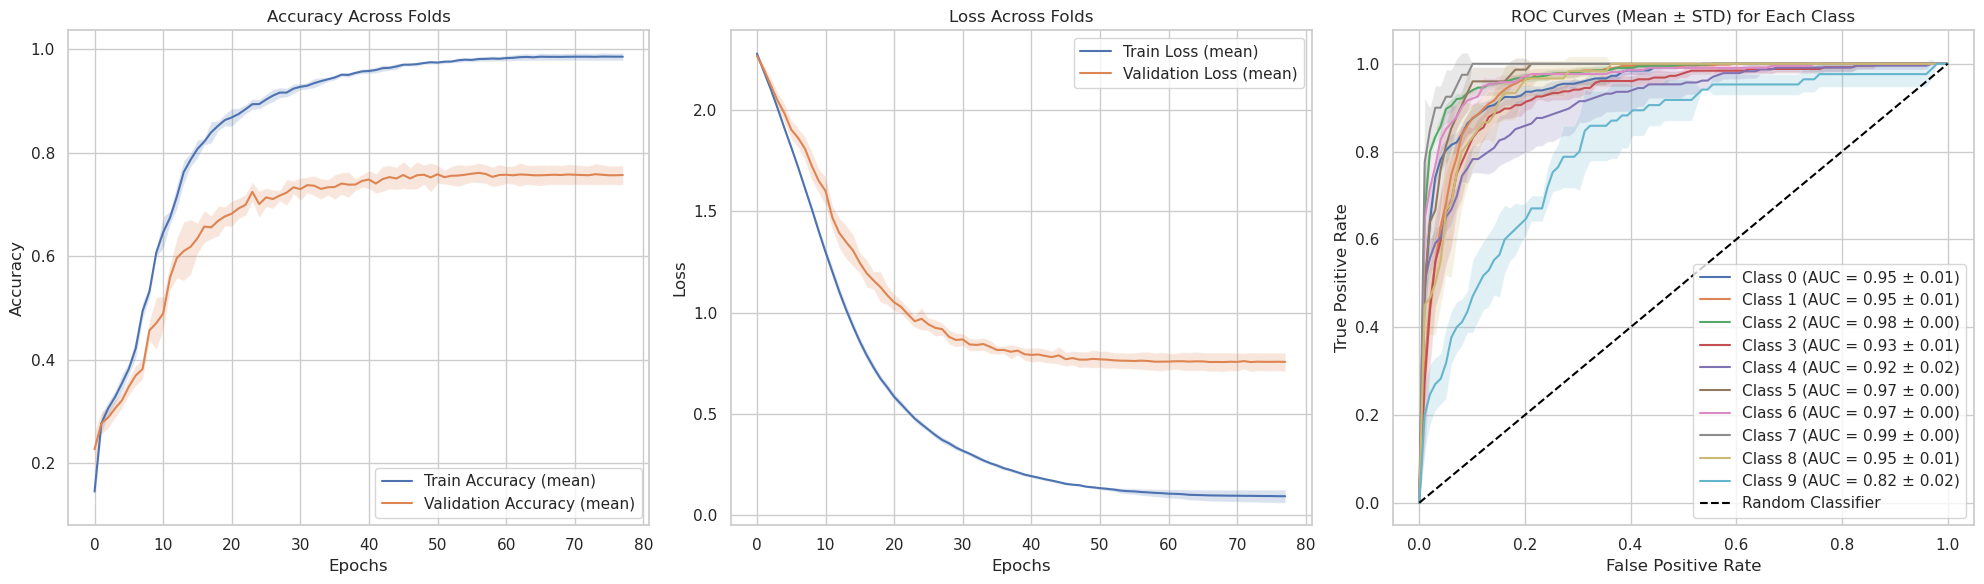

In [27]:
# Plot the results for all folds
plot_cross_validation_results(histories_cnn, test_accuracies_cnn,
                              y_test, y_pred_probas_cnn)

### Test ResNet model 

In [28]:
from keras import Model
from tensorflow.keras.layers import (BatchNormalization, AveragePooling1D, 
                                     Activation, Add)

In [29]:
def residual_module(input, channels, stride=1, kernel_size=3):
    x_shortcut = input
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv1D(channels, (1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
    output = Add()([x, x_shortcut])
    return(output)

def create_resnet_model(n_residual=30, learning_rate=0.001):
    # Initialize the model
    inputs = Input(shape=(400, 20))
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)
    avgpool = AveragePooling1D((2), strides=(1))(residual_i)
    flatten = Flatten()(avgpool)
    output = Dense(10, activation="softmax")(flatten)
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'])

    return model

: 

In [30]:
# Cross-validate ResNet model
histories_resnet, test_accuracies_resnet, y_pred_probas_resnet = cross_validate_model(
    create_model_func=create_resnet_model,
    x_train=x_train, y_train=y_train,
    x_test=x_test, y_test=y_test,
    class_weights_dict=class_weights_dict,
    model_type='resnet'
)

Training fold 1/5...
Epoch 8: early stopping
Validation accuracy for fold 1: 21.39%
Test accuracy for fold 1: 21.24%
Training fold 2/5...
Epoch 9: early stopping
Validation accuracy for fold 2: 18.81%
Test accuracy for fold 2: 22.06%
Training fold 3/5...
Epoch 9: early stopping
Validation accuracy for fold 3: 24.48%
Test accuracy for fold 3: 22.68%
Training fold 4/5...
Epoch 8: early stopping
Validation accuracy for fold 4: 14.47%
Test accuracy for fold 4: 14.02%
Training fold 5/5...


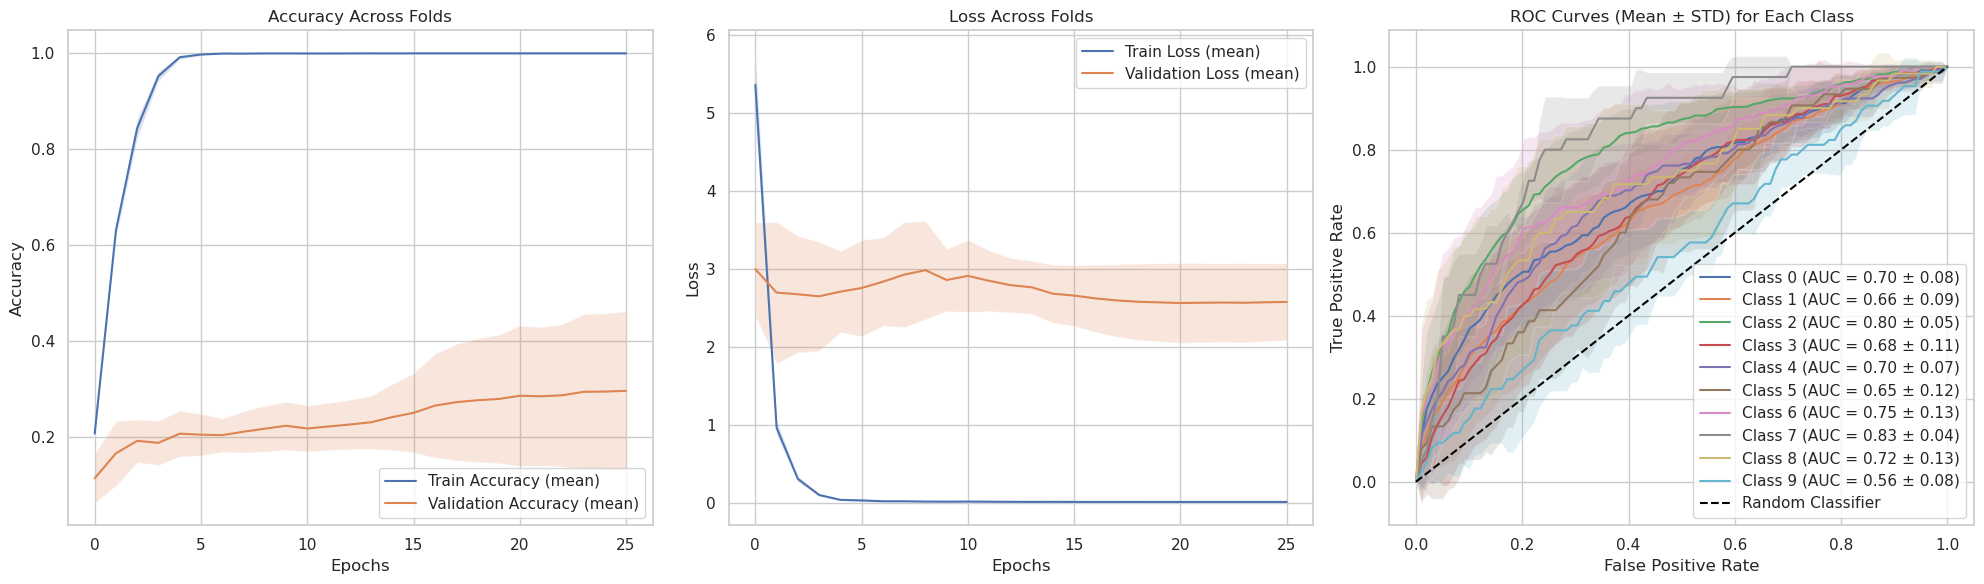

In [31]:
# Plot the results for all folds
plot_cross_validation_results(histories_resnet, test_accuracies_resnet,
                              y_test, y_pred_probas_resnet)

### Evaluate significance of the results

In [33]:
from scipy.stats import kruskal

: 

In [ ]:
# Perform Kruskal-Wallis test on ResNet, CNN, and Dense
stat, p_value = kruskal(test_accuracies_resnet, 
                        test_accuracies_cnn, 
                        test_accuracies_dense)

print(f"Kruskal-Wallis Test: statistic={stat}, p-value={p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")